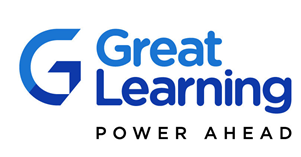

# AIML Online Capstone - Pneumonia Detection Challenge

The goal is to build a pneumonia detection system, to locate the position of
inflammation in an image.

Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear
black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.
While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia
related.

In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates
that while pneumonia was determined not to be present, there was nonetheless some type of
abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They
contain a combination of header metadata as well as underlying raw image arrays for pixel data

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pydicom as dcm
import math
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model

import cv2

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 

import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

import math

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnetProcess_input

## **Reading the Data Set and EDA**

In [ ]:
## reading the labels data set and showing first few records
labels = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
labels.head()

In [ ]:
labels.shape
## There are 30227 records and 6 rows

In [ ]:
labels.info()
## There are 30227 rows 
## there are 30277 target as well
## x ,y, WIdth and height count is 9555 , the others are null

In [ ]:
## we can see that all the null column values are with Target 0 indicating that those patients do not have penumonia
labels[labels.isnull().any(axis=1)].Target.value_counts()

In [ ]:
## we can see that all the non null column values are with Target 1 indicating that those patients have pneumonia
labels[~labels.isnull().any(axis=1)].Target.value_counts()

In [ ]:
## Distubution of Targets , there are 20672 records with no pneumonia and 9555 with pneumonia
labels.Target.value_counts()

In [ ]:
## Disturbution of Target, there are 31% of patients with pneumonia and the remaining are no pneumonia
## There is a class imbalance issue
label_count=labels['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

In [ ]:
print("Are there Unique Patients In Data Set ?? " ,labels['patientId'].is_unique)
## There is no point in finding unique for x,y,width and height as there can be duplcaie values in them
## There are duplicate patients in the data set

In [ ]:
#labels.loc[labels.index.repeat(labels.patientId)]
duplicateRowsDF = labels[labels.duplicated(['patientId'])]
duplicateRowsDF.shape

## There are 3543 duplicates

In [ ]:
duplicateRowsDF.head(2)

In [ ]:
## Examining one of the patient id which is duplicate , we can see that the x,y, widht and height is not the same
## This indicates that the same patient has two bounding boxes in the same dicom image
labels[labels.patientId=='00436515-870c-4b36-a041-de91049b9ab4']

In [ ]:
labels[labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

# **Reading the class Info Data Set**

In [ ]:
## Reading the classes label , 
class_labels = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
class_labels.head()


In [ ]:
class_labels.shape
## There are 30277 rows and two columns , 30277 rows same as the labels data set

In [ ]:
class_labels.info()
## There are no null columns 

In [ ]:
class_labels['class'].value_counts()

## there are 8851 normal cases , person with lung opactiry are 9555 and No Lung Opacity / Not Normal are 11821 

In [ ]:
## Disturbution of Classes, there are 39% of patients with No Lung opacity , 29.3% Normal 
## and the remaining are with Lung Opacity
label_count=class_labels['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [ ]:

#labels.loc[labels.index.repeat(labels.patientId)]
duplicateClassRowsDF = class_labels[class_labels.duplicated(['patientId'])]
duplicateClassRowsDF.shape

## There are 3543 duplicates similar to the labels dataset

In [ ]:
duplicateClassRowsDF.head(2)

In [ ]:
## The same patient id has the same class even though they are duplicate
class_labels[class_labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

Merging the class and labels data set into training dataset

In [ ]:
# Conctinating the two dataset - 'labels' and 'class_labels':
training_data = pd.concat([labels, class_labels['class']], axis = 1)

training_data.head()

In [ ]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('Class and Target  Distrubution')

## it shows that class distrubution grouped by Target 
## Target 0 has only Normal or No Lung Opacity class
## Target 1 has only Lung Opacity class

In [ ]:
## ANalysing the dicom image
import matplotlib.patches as patches

def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

Displaying Chest Xray Images of Patients who have Pneuomina

In [ ]:
## checking few images which has pneuonia 
inspectImages(training_data[training_data['Target']==1].sample(9))

In [ ]:
## checking few images which does not have pneuonia 
inspectImages(training_data[training_data['Target']==0].sample(9))

Reading the Dicom images meta data and appending it to the training set

In [ ]:
## DCIM image contain the meta data alon with it, 
## Function to read the dcim data and appending to the resultset
def readDCIMData(rowData):
    dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format(rowData.patientId)
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge


In [ ]:
## Reading the image data and append it to the training_data dataset
training_data['sex'], training_data['age'] = zip(*training_data.apply(readDCIMData, axis=1))


In [ ]:
training_data.info()
## There are 30227  records
## sex and age also have the smae count indicating that there are no images missing every patient has an dicom image 
## Age should be a numeric , currently it is an objetc

In [ ]:
# Converting age to Numeric as the current data type is a String
training_data['age'] = training_data.age.astype(int)


In [ ]:
training_data.describe(include="all").T
## The mean age is 46 years , where as minimum age is 1 year and the max age is 155 which seems to be an outlier
## 50% of the patiens are of aroudn 49 age , the std deviation is 16 which sugges that age is not normally distubuted

In [ ]:
training_data.sex.value_counts()
## there are only two genders 

In [ ]:
## Distbution of Sex Among the tragets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and Target for Chest Exams')

## the number of males in both category are higher than women

In [ ]:
## Distbution of Sex Among the classes
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('class')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest Exams')

## the number of males in all classes are higher than women

In [ ]:
sns.distplot(training_data.age) 
# plots the distrubution of age
## Looks like normal distubution of age

In [ ]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='class', y='age', data=training_data, palette='muted')  # barplot'
## This is the distubution of Age with class, maximum age of person with pneuomina is arund 45

In [ ]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='Target', y='age', data=training_data, palette='muted')  # barplot'
## This is the distubution of Age with class, maximum age of person with pneuomina is arund 45

In [ ]:
plt.figure(figsize=(15,7))
sns.boxplot(x='class', y='age', data= training_data)
plt.show()

## The  class which has no pneuomia has few outliers , theie age is somewhere aroun 150 years

In [ ]:
print('Distribution of `Age`: Overall and Target = 1')
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(training_data['age']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(training_data.loc[training_data['Target'] == 1, 'age']).set_title('Distribution of PatientAge who have pneumonia'))

## Overall Distrubution of Age looks normal with very little skwe
## Distubution of Patients afe who have penuomonia are a left skewed 

In [ ]:
corr = training_data.corr()
plt.figure(figsize=(12,5))

sns.heatmap(corr,annot=True)

## There is high corelation between widht and height


### **MODEL BUILDING**

In [ ]:
## Just taking a 200 samples from the dataset
sample_trainigdata = training_data.groupby('class', group_keys=False).apply(lambda x: x.sample(800))

In [ ]:
## Checking the training data set with class distbution 
sample_trainigdata["class"].value_counts()

In [ ]:
sample_trainigdata.info()

In [ ]:
## Pre Processing the image
from tensorflow.keras.applications.mobilenet import preprocess_input

images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels


In [ ]:
## Reading the images into numpy array
images,labels = populateImage(sample_trainigdata)

In [ ]:
images.shape , labels.shape
## The image is of 128*128 with 3 channels

In [ ]:
## Checking one of the converted image 
plt.imshow(images[100])

In [ ]:
## check the unique labels
np.unique(labels),len(np.unique(labels))

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
# define model
from tensorflow.keras import losses,optimizers
from tensorflow.keras.layers import Dense,  Activation, Flatten,Dropout,MaxPooling2D,BatchNormalization
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from sklearn.model_selection import StratifiedKFold
%matplotlib inline
#Test Train Split
from sklearn.model_selection import train_test_split
#Feature Scaling library
from sklearn.preprocessing import StandardScaler
#import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense ,LeakyReLU
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
## encoding the labels
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [ ]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)



In [ ]:
## FUnction to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result



In [ ]:
## CNN Model without transfer learning , we start with 32 filters with 5,5 kernal and no padding , then 64 and 128 wiht drop layers in between 
## And softmax activaation as the last layer
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [ ]:
# Model Summary
cnn = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

In [ ]:
## Training for 30 epocs with batch size of 30
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 30, 
                  validation_data = (X_val,y_val),
                  batch_size = 30)

In [ ]:
## evakualting the acuracy , we have only got accuracy of 43-46% where as the training accuracy is around 60%
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

In [ ]:
## PLottting the accuracy vs loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(30)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#The training and Validation loss is almost same, but for the training and validation accuracy chart, 
#the validation accuracy falls down in the later epochs, this could be because we have only taken 200 images for processing.

In [ ]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

#Class 0 ,1 and 2
#Class 0 is Lung Opacity
#Class 1 is No Lung Opacity/Normal, the model has predicted mostly wrong in this case to the Target 0. Type 2 error
#Class 2 is Normal


In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

In [ ]:
## Creating a Copy
X_train1 = X_train.copy()
X_val1 = X_val.copy()
X_test1 = X_test.copy()

**CNN with Tranfer learning using VGG16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

##VGGNet is a well-documented and globally used architecture for convolutional neural network
## Include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)


In [ ]:
## Adding two hidden later and one softmax layer as an output layer
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


cnn_VGG16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_VGG16_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Early stopping whe validation accuracy does not change for 7 iteration 
es = EarlyStopping(monitor='val_accuracy', mode='auto', patience=7,  restore_best_weights=True)

#Trainign the model
history = cnn_VGG16_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val) ,callbacks=es)

In [ ]:
test_ds = preprocess_input(X_test1) 
fcl_loss, fcl_accuracy = cnn_VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

## The Test accuracy score if 64% but the training accurayc is 100 , this model is overfit

In [ ]:
resultsDf1 = pd.concat([resultDF, createResultDf("CNN With VGG16",0.9571,fcl_accuracy)])


In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf1[data+"_"+subData] = reportData[data][subData]

resultsDf1

**CNN with ResNet50**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

resnet_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train[0].shape)
#model = VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))

train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

cnn_resnet_model = models.Sequential([
    resnet_base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_resnet_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history =cnn_resnet_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))

In [ ]:
fcl_loss, fcl_accuracy = cnn_resnet_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

## Thw accuracy of test score is 58% abut training accuracy is 99% again it is an overfit model

In [ ]:
resultsDf2 = pd.concat([resultsDf1, createResultDf("CNN With ResNet50",history.history['accuracy'][-1],fcl_accuracy)])


In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf2[data+"_"+subData] = reportData[data][subData]



In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
# Predict the values from the validation dataset
Y_pred = cnn_resnet_model.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [ ]:
resultsDf2.head()
## with transfer learning we have the issue of overfitting, it does well in the training data set but not well in test
## Without TRansfer learning , the accuracy is not high but the model is general
## We will need to pre process tha image further and take more sample to conclude 

# Bounding Box Prediction : UNet

In [ ]:
labels = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")


In [ ]:
## Getting the first 5000 data set for traingin and the next 5000 for validations
train_CombinedData = labels[0:5000]
validate_CombinedData = labels[5000:10000]

train_CombinedData.fillna(0, inplace=True)
validate_CombinedData.fillna(0, inplace=True)


In [ ]:
## Checking training data distuburtion , they have almos the same target distubution
train_CombinedData.Target.value_counts()

# ** Creating Custom Train Generator. This will read the files in batches of 10 while training the model**

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input 

#
BATCH_SIZE = 10

## Image Size to be scaled
IMAGE_SIZE = 224


## Actual Image size 
IMG_WIDTH = 1024
IMG_HEIGHT = 1024


class TrainGenerator(Sequence):

    def __init__(self,  _labels):       
        self.pids = _labels["patientId"].to_numpy()
        self.coords = _labels[["x", "y", "width", "height"]].to_numpy()
        self.coords = self.coords * IMAGE_SIZE / IMG_WIDTH
        

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    
    """
    The contrast of an image is enhanced when various shades in the image becomes more distinct.
    We can do so by darkening the shades of the darker pixels and vice versa. 
    This is equivalent to widening the range of pixel intensities. To have a good contrast, 
    the following histogram characteristics are desirable:

    1) the pixel intensities are uniformly distributed across the full range of values (each intensity value is equally probable), and
    2) the cumulative histogram is increasing linearly across the full intensity range.

    Histogram equalization modifies the distribution of pixel intensities to achieve these characteristics.
    """

    def __doHistogramEqualization(self,img):
        # Pre processing Histogram equalization
        histogram_array = np.bincount(img.flatten(), minlength=256)
        #normalize
        num_pixels = np.sum(histogram_array)
        histogram_array = histogram_array/num_pixels
        #normalized cumulative histogram
        chistogram_array = np.cumsum(histogram_array)
        """
        STEP 2: Pixel mapping lookup table
        """
        transform_map = np.floor(255 * chistogram_array).astype(np.uint8)
        """
        STEP 3: Transformation
        """
        img_list = list(img.flatten())

        # transform pixel values to equalize
        eq_img_list = [transform_map[p] for p in img_list]

        # reshape and write back into img_array
        img = np.reshape(np.asarray(eq_img_list), img.shape)

        return img

    def __getitem__(self, idx): # Get a batch
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords
        batch_pids = self.pids[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image pids    
        
        batch_images = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE))
        for _indx, _pid in enumerate(batch_pids):
            _path = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format(_pid)
            _imgData = dcm.read_file(_path)

            img = _imgData.pixel_array 
#             img = np.stack((img,)*3, axis=-1) # Expand grayscale image to contain 3 channels

            # Resize image
            resized_img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
            
            resized_img = self.__doHistogramEqualization(resized_img)
        
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+width] = 1

        return batch_images, batch_masks

In [ ]:
trainUNetDataGen = TrainGenerator( train_CombinedData)
validateUNetDataGen = TrainGenerator( validate_CombinedData)


In [ ]:
# To show image with mask
def showMaskedImage(_imageSet, _maskSet, _index) :
    maskImage = _imageSet[_index]

    maskImage[:,:,0] = _maskSet[_index] * _imageSet[_index][:,:,0]
    maskImage[:,:,1] = _maskSet[_index] * _imageSet[_index][:,:,1]
    maskImage[:,:,2] = _maskSet[_index] * _imageSet[_index][:,:,2]

    plt.imshow(maskImage[:,:,0])

In [ ]:
## One of the pre processed image from custom train generotr
imageSet0 = trainUNetDataGen[1][0][1]
plt.imshow(imageSet0)

In [ ]:
## Masks for the same
imageSet0 = trainUNetDataGen[2][0]
maskSet0 = trainUNetDataGen[2][1]    
showMaskedImage(imageSet0, maskSet0, 5)

In [ ]:
LR = 1e-4

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization ,Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet , VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D


**UNET USING MobileNet**

In [ ]:
ALPHA = 1.0
def create_UNetModelUsingMobileNet(trainable=True):
    """Function to create UNet architecture with MobileNet.
        
    Arguments:
        trainable -- Flag to make layers trainable. Default value is 'True'.
    """
    # Get all layers with 'imagenet' weights
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet") 
    # Top layer is last layer of the model
    
    # Make all layers trainable
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    convLayer_112by112 = model.get_layer("conv_pw_1_relu").output
    convLayer_56by56 = model.get_layer("conv_pw_3_relu").output
    convLayer_28by28 = model.get_layer("conv_pw_5_relu").output
    convLayer_14by14 = model.get_layer("conv_pw_11_relu").output
    convLayer_7by7 = model.get_layer("conv_pw_13_relu").output
    # The last layer of mobilenet model is of dimensions (7x7x1024)

    # Start upsampling from 7x7 to 14x14 ...up to 224x224 to form UNET
    # concatinate with the original image layer of the same size from MobileNet
    x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
    x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
    x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
    x = UpSampling2D(name="unet_last")(x) # upsample to 224x224

    # Add classification layer
    x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x) 

    return Model(inputs=model.input, outputs=x)

In [ ]:
## Build a model 
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
model = create_UNetModelUsingMobileNet(input_shape)
model.summary()

In [ ]:
#dice_coef 2 * the Area of Overlap divided by the total number of pixels in both images
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

## Loss is 1 - the coefficent of two images
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
## Call Backs for ealy stopping and reduce learning rate 
## Reduce the learning rate when teh validation loss is same for 4 epocs
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [ ]:
## Optimiser , metrics and loss for the model
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)


In [ ]:
## Running the model
train_steps = len(trainUNetDataGen)//BATCH_SIZE
valid_steps = len(validateUNetDataGen)//BATCH_SIZE

if len(trainUNetDataGen) % BATCH_SIZE != 0:
    train_steps += 1
if len(validateUNetDataGen) % BATCH_SIZE != 0:
    valid_steps += 1


history = model.fit(trainUNetDataGen,
                        epochs=16,
                        steps_per_epoch=train_steps,
                        validation_data=validateUNetDataGen,
                        callbacks=callbacks,
                        use_multiprocessing=True,
                        workers=4,
                        validation_steps=valid_steps,                      
                        shuffle=True)


In [ ]:
## PLot Matrix between training and validation data
plt.figure(figsize=(8, 5))
plt.grid(True)
plt.plot(history.history['dice_coef'],     label='Train Dice-Coef',      color = "green" );
plt.plot(history.history['val_dice_coef'], label='Val Dice-Coef',  color = "yellow");
plt.plot(history.history['loss'],         label='Train Loss',          color = "red"   );
plt.plot(history.history['val_loss'],     label='Val Loss',      color = "orange");
plt.title("Validation and Training - Loss and Dice Coefficient vs Epoch")
plt.xlabel("Epoch")
plt.legend();

val_dice-oefficient value is very low and pretty much a flat curve, indicating underfitting indicating model has not learnt sufficiently. It is steadily increasing, not sufficient training(more epochs needed).  

We have used an image size of 224x224 as against the original size of 1024x1024. Using a higher resolution, could also improve training capacity 

<li>Hyper-parameter tuning, image_augmentation, using different architectures will help in increasing model performance and generalization.


In [ ]:
##Preparing test data , picked up random 20 images
test_CombinedData = labels[15000:15020]
test_CombinedData.fillna(0, inplace=True)

In [ ]:
##Check target distrubution in test dataset, there are both the classes available with equal sdistrubution
test_CombinedData.Target.value_counts()

In [ ]:
## Setting the custom generator for test data
testUNetDataGen = TrainGenerator(test_CombinedData)

In [ ]:
## evaluating the model
test_steps = (len(testUNetDataGen)//BATCH_SIZE)
if len(testUNetDataGen) % BATCH_SIZE != 0:
    test_steps += 1

model.evaluate(testUNetDataGen)

## Model evaluation , dice coef = 50% m recall is good  wiht 61% , precission is very low , of about 43.37%

In [ ]:
## Precidt the test data that we have
pred_mask = model.predict(testUNetDataGen)


In [ ]:
test_CombinedData = test_CombinedData.reset_index()


In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = []
y_True = []
imageList = []
predMaskTemp = []
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
def getPredictions(test_CombinedData):
    masks = np.zeros((int(test_CombinedData.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))

    for index, row in test_CombinedData.iterrows():
        patientId = row.patientId
#         print(patientId)

        classlabel = row["Target"]
        dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        resized_img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH), interpolation = cv2.INTER_LINEAR)
        predMaskTemp.append(pred_mask[index])
        iou = (pred_mask[index] > 0.5) * 1.0
        y_pred.append((1 in iou) * 1)
        imageList.append(resized_img)
        y_True.append(classlabel)
        x_scale = IMAGE_HEIGHT / 1024
        y_scale = IMAGE_WIDTH / 1024

        if(classlabel == 1):
            x = int(np.round(row['x'] * x_scale))
            y = int(np.round(row['y'] * y_scale))
            w = int(np.round(row['width'] * x_scale))
            h = int(np.round(row['height'] * y_scale))
            masks[index][y:y+h, x:x+w] = 1

        
        
    tmpImages = np.array(imageList)
    tmpMask = np.array(predMaskTemp)
    originalMask = np.array(masks)
    return (y_True,y_pred,tmpImages,tmpMask ,originalMask)
    
def print_confusion_matrix(y_true, y_pred):
    '''Function to print confusion_matrix'''

    # Get confusion matrix array
    array = confusion_matrix(y_true, y_pred)    
    df_cm = pd.DataFrame(array, range(2), range(2))

    print("Total samples = ", len(test_CombinedData))

    # Plot heatmap and get sns heatmap values
    sns.set(font_scale=1.4); # for label size
    result = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cbar=False); 

    # Add labels to heatmap
    labels = ['TN=','FP=','FN=','TP=']
    i=0
    for t in result.texts:
        t.set_text(labels[i] + t.get_text())
        i += 1
    
    plt.xlabel("Predicted Values")
    plt.ylabel('True Values')
    plt.show()
    return
    

    


In [ ]:
## Create predictions map
y_true,y_pred ,imagelist , maskList , originalMask = getPredictions(test_CombinedData)


In [ ]:

dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format('9358d1c5-ba61-4150-a233-41138208a3f9')
dcm_data = dcm.read_file(dcm_file)
img = dcm_data.pixel_array
plt.imshow(imagelist[12])

In [ ]:
## Visualising the train and output data 
##
fig = plt.figure(figsize=(15, 15))

a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(imagelist[1])
a.set_title('Original Images ',fontsize=20)


a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(imagelist[12])

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(imagelist[13])

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(imagelist[15])


fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)

imgplot = plt.imshow(originalMask[1])
a.set_title('Oringial Mask (Truth) ',fontsize=20)

a.set_xlabel('Pneumonia {}:'.format(y_true[1]), fontsize=20)


a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(originalMask[12])
a.set_xlabel('Pneumonia {}:'.format(y_true[12]), fontsize=20)


a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(originalMask[13])
a.set_xlabel('Pneumonia {}:'.format(y_true[13]), fontsize=20)


a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(originalMask[15])
a.set_xlabel('Pneumonia {}:'.format(y_true[15]), fontsize=20)



fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
a.set_title('Predicted Mask  ',fontsize=20)
imgplot = plt.imshow(maskList[1])
a.set_xlabel('Pneumonia {}:'.format(y_pred[1]), fontsize=20)

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(maskList[12])
a.set_xlabel('Pneumonia {}:'.format(y_pred[12]), fontsize=20)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(maskList[13])
a.set_xlabel('Pneumonia {}:'.format(y_pred[13]), fontsize=20)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(maskList[15])
a.set_xlabel('Pneumonia {}:'.format(y_pred[15]), fontsize=20)


## we could see that the first  one is mis classifed
## Second one is classified correctly , there are no masks
## Thrid is predcited correctly and the bouding box is also almost at the same position
## fourth is predicted correctly but there are two boudnign boxes, this culd be because there are duplicate patient id and we are picking only one mask to display inte Truth

In [ ]:
print_confusion_matrix(y_true,y_pred )
## There are two False Postive for Target 1

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true,y_pred))

<font color=red> 
    <li>Recall socre is quite high for pneumonia class(target = 1), even for a very low dice-coefficient score for image mask prediction. This is a good score, because it indicates that 99% of patients who are positive are detected correctly by this model. 
    <li>Precision score is however low indicating only 83% of the predictions are correct. This is largely due to a high amount of false positives, as indicated in the confusion matrix.
    <li>The accuracy score is  0.85%, w This probably can improve as the model trains with more number of samples, that will help it to distinguish non-pneumonia images better.

1)	We have done the EDA 

2)	We have done the pre-processing of the dicom images

3)	We have built CNN model for classification without transfer learning and with Transfer learning

4)	Currently with the limited sample data set that we have taken we have found the CNN model without transfer learning was the most general model even though the accuracy was not very high

5)	We have built UNET model for regression using VGG16 Pre trained model 

6) We can improve the dice loss by image augmentation , increasing the sample size and hyper tuning
